Initial Model - Based off similar strucutre in example code

In [ ]:
# Step 1: Set Up the Environment
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import os

In [39]:
# Define paths
data_dir = 'data/EuroSAT_RGB'
train_ratio = 0.8

In [40]:
# Step 2: Load and Transform Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [41]:
# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        
        # To automatically determine the input size for fc1
        self._to_linear = None
        self.convs(torch.randn(1, 3, 64, 64))  # Pass a dummy input to calculate

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

    def convs(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        if self._to_linear is None:
            self._to_linear = x.numel()
        return x

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = Net().to(device)

In [43]:
# Step 4: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

C:\Users\mbmma\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/10, Loss: 1.2449
Epoch 2/10, Loss: 0.8543
Epoch 3/10, Loss: 0.7101
Epoch 4/10, Loss: 0.6090
Epoch 5/10, Loss: 0.5036
Epoch 6/10, Loss: 0.4325
Epoch 7/10, Loss: 0.3537
Epoch 8/10, Loss: 0.3194
Epoch 9/10, Loss: 0.2825
Epoch 10/10, Loss: 0.2560


In [36]:
# Step 5: Evaluate the Model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7274


The first model we created gives us back a test accuracy of 72.74%

C:\Users\mbmma\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


IndexError: index 10 is out of bounds for axis 0 with size 10

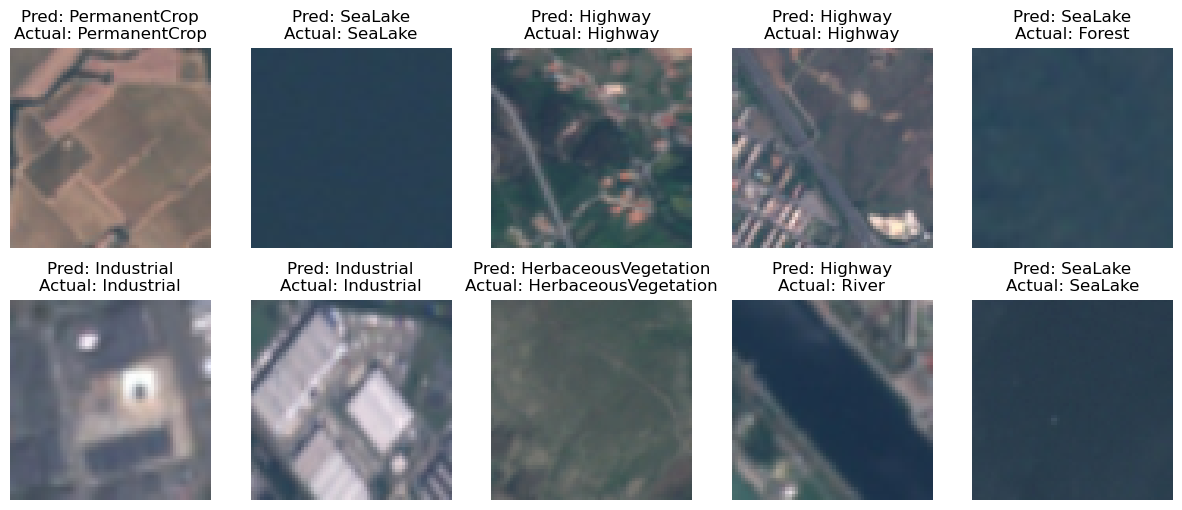

In [37]:
# Show some example images with predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, (inputs, labels) in enumerate(test_loader):
    if i >= 10:
        break
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(inputs.size(0)):
        if j >= 5:
            break
        img = inputs[j].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
        axes[2*i+j].imshow(img)
        axes[2*i+j].set_title(f'Pred: {dataset.classes[preds[j]]}\nActual: {dataset.classes[labels[j]]}')
        axes[2*i+j].axis('off')

plt.tight_layout()
plt.show()

The pictures above are 10 of the testing images fed into our neural network with its actual class listed as well as the predicted image classification. In this sample of 10 we have an accuracy of 80% with the errors being a River predicted as a highway and a forest predicted as a sea.

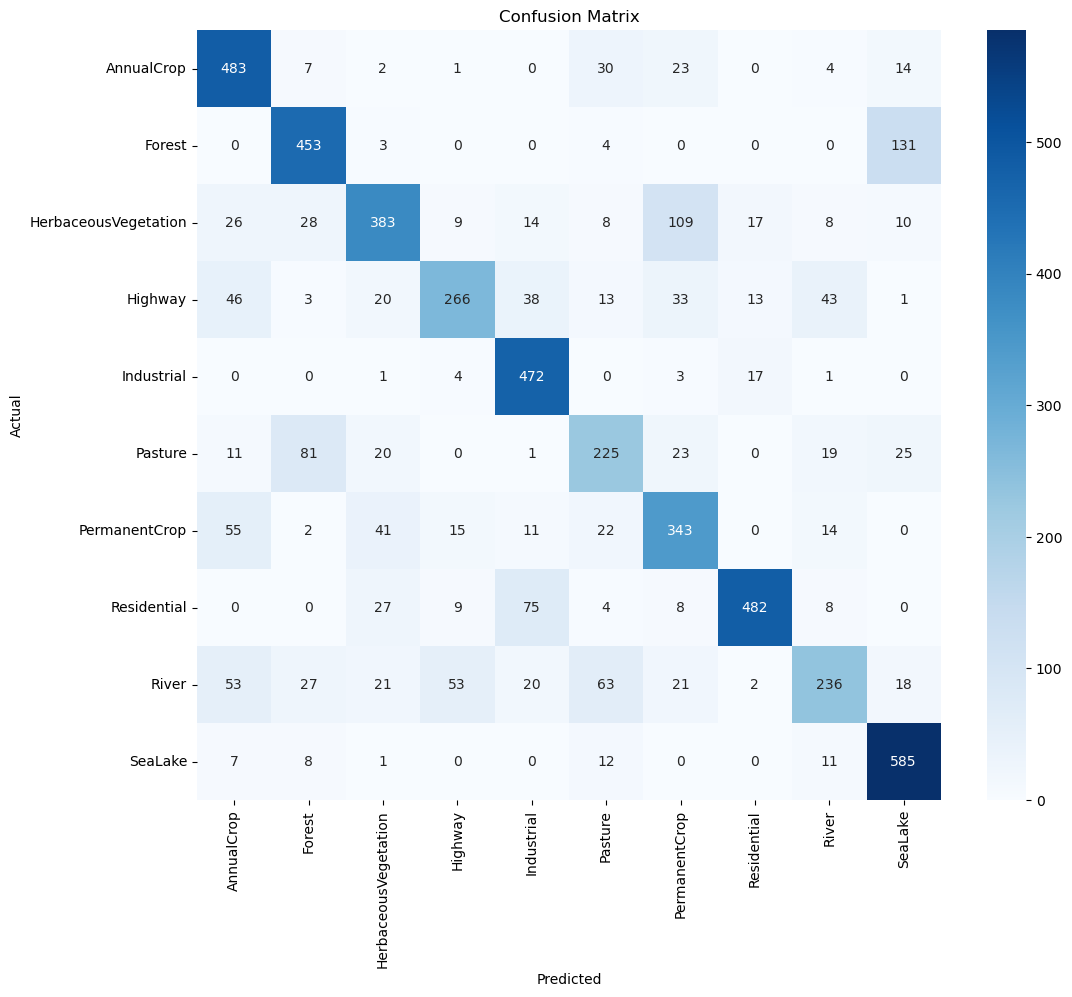

In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Above is the resulting confusion matrix from the first attempt at the model. Based on its results it predicts incorrectly on rivers and pastures the most. Specificly rivers have a lot of errors with most other types besides residential areas. While pastures are confused with forests, bodies of water and permanent crops the most. But it is never confused with Highways or residential areas. The most accurate classification is SeaLake which are bodies of water. Very few SeaLake types are confused with other types, the most common mistake is a pasture or a river. The most common mistaken for a SeaLake is a forest.

In [ ]:
##############################################################################################

Improved model based off of research and tweaks to the strucutre to improve the neurel network classification model.

In [47]:
# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        # Third Convolutional Block
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Fourth Convolutional Block
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 11)  # Assuming 11 classes in the dataset
        
        # Dropout layers
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First Convolutional Block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # Second Convolutional Block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # Third Convolutional Block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # Fourth Convolutional Block
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ImprovedNet().to(device)

In [49]:
# Step 4: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/10, Loss: 0.9796
Epoch 2/10, Loss: 0.6534
Epoch 3/10, Loss: 0.5385
Epoch 4/10, Loss: 0.4485
Epoch 5/10, Loss: 0.3818
Epoch 6/10, Loss: 0.3443
Epoch 7/10, Loss: 0.3115
Epoch 8/10, Loss: 0.2860
Epoch 9/10, Loss: 0.2642
Epoch 10/10, Loss: 0.2403


In [50]:
# Step 5: Evaluate the Model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9281


The improved model gives us an accuracy of 92.81% which is much better than the original model.

IndexError: index 10 is out of bounds for axis 0 with size 10

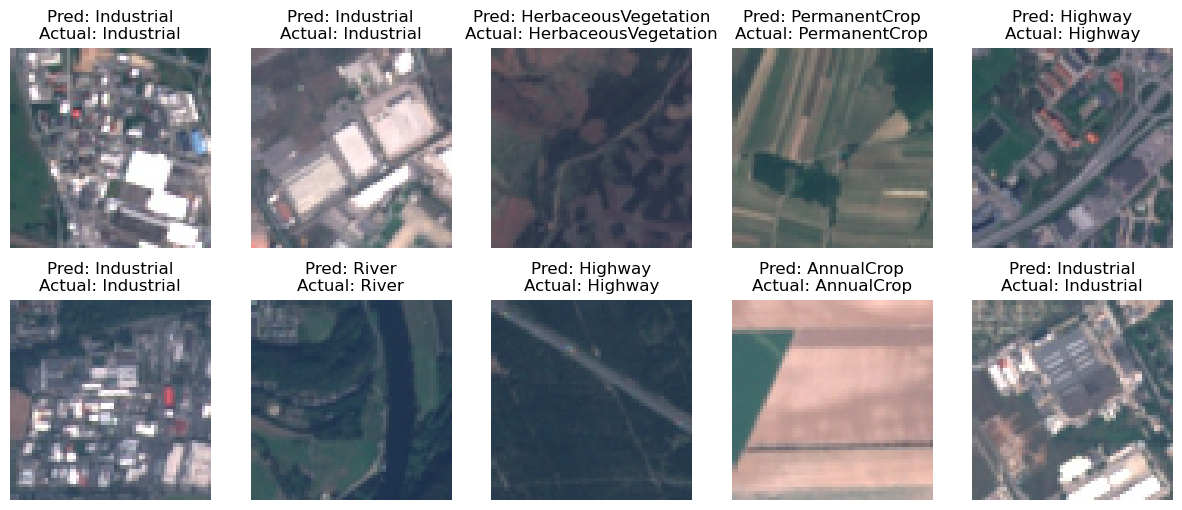

In [51]:
# Show some example images with predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, (inputs, labels) in enumerate(test_loader):
    if i >= 10:
        break
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(inputs.size(0)):
        if j >= 5:
            break
        img = inputs[j].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
        axes[2*i+j].imshow(img)
        axes[2*i+j].set_title(f'Pred: {dataset.classes[preds[j]]}\nActual: {dataset.classes[labels[j]]}')
        axes[2*i+j].axis('off')

plt.tight_layout()
plt.show()

The above images are 10 inputs in the testing data and classified by the improved model. With my improved model the model predicts all 10 correctly.  

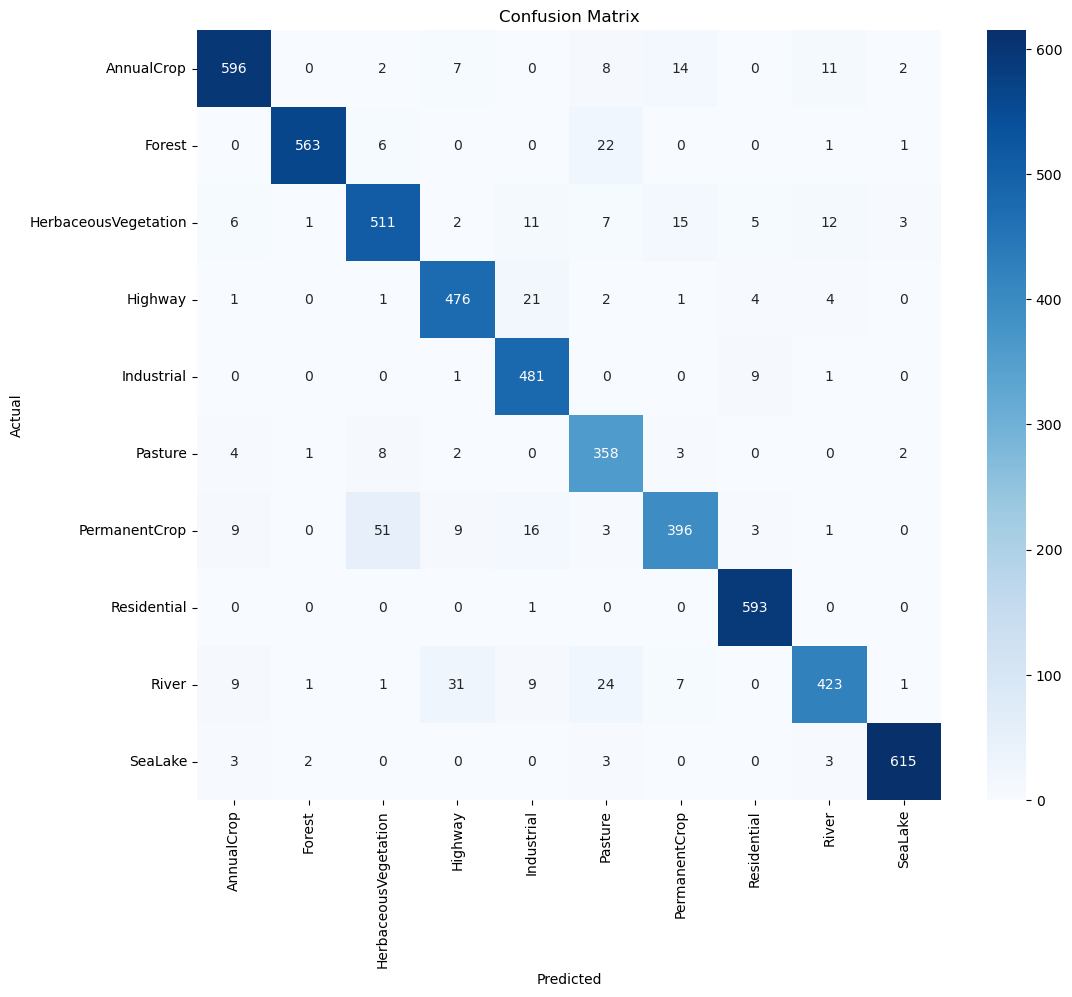

In [52]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Above is the confusion matrix for the improved neural net. Like the original model, the most accurate classification seems to be the SeaLake. Only about half of the classifications are misclassified as Sealakes. All of which have 3 or less miscassifications. While classifications that are incorrectly predicted as Sealakes has a similar structure. The most inaccurate classification seems to be Pastures again.  Not many pastures are misclassified as other types but a few standouts are Rivers and forets which are incorrectly classified as pastures. The most common mistake in this model is PermanentCrops classified at HerbaceousVegetation which makes sences as they are both plant growths.